##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Text classification with an RNN

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/text/tutorials/text_classification_rnn"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/text/blob/master/docs/tutorials/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/text/blob/master/docs/tutorials/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/text/docs/tutorials/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This text classification tutorial trains a [recurrent neural network](https://developers.google.com/machine-learning/glossary/#recurrent_neural_network) on the [IMDB large movie review dataset](http://ai.stanford.edu/~amaas/data/sentiment/) for sentiment analysis.

## Setup

In [2]:
import pandas as pd
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

Import `matplotlib` and create a helper function to plot graphs:

In [3]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])



# Get Datasets and Dataframes

In [4]:
testingDatasets = []
trainingDatasets = []

for i in range(2):
  testingDatasets.append(pd.read_json('https://raw.githubusercontent.com/budzianowski/multiwoz/master/data/MultiWOZ_2.2/test/dialogues_00' + str(i+1) + '.json'))

for i in range(9):
  trainingDatasets.append(pd.read_json('https://raw.githubusercontent.com/budzianowski/multiwoz/master/data/MultiWOZ_2.2/train/dialogues_00' + str(i+1) + '.json'))

for i in range(8):
  trainingDatasets.append(pd.read_json('https://raw.githubusercontent.com/budzianowski/multiwoz/master/data/MultiWOZ_2.2/train/dialogues_0' + str(i+10) + '.json'))

testingDatasets = pd.concat([testingDatasets[0], testingDatasets[1]])
trainingDatasets = pd.concat([trainingDatasets[0], trainingDatasets[1],trainingDatasets[2],trainingDatasets[3],trainingDatasets[4],trainingDatasets[5],trainingDatasets[6],trainingDatasets[7],trainingDatasets[8],trainingDatasets[9],trainingDatasets[10],trainingDatasets[11],trainingDatasets[12],trainingDatasets[13],trainingDatasets[14],trainingDatasets[15],trainingDatasets[16]])
testingDatasets

,dialogue_id,services,turns
0,MUL0484.json,"[attraction, train]","[{'frames': [{'actions': [], 'service': 'train..."
1,PMUL4462.json,"[restaurant, taxi, attraction]","[{'frames': [{'actions': [], 'service': 'resta..."
2,PMUL0320.json,"[restaurant, taxi, hotel]","[{'frames': [{'actions': [], 'service': 'hotel..."
3,MUL2155.json,"[train, hotel]","[{'frames': [{'actions': [], 'service': 'hotel..."
4,PMUL0815.json,"[restaurant, train]","[{'frames': [{'actions': [], 'service': 'resta..."
...,...,...,...
483,MUL0306.json,"[restaurant, train]","[{'frames': [{'actions': [], 'service': 'train..."
484,MUL2228.json,"[train, hotel]","[{'frames': [{'actions': [], 'service': 'train..."
485,MUL0641.json,"[train, hotel]","[{'frames': [{'actions': [], 'service': 'hotel..."
486,PMUL1194.json,"[attraction, train]","[{'frames': [{'actions': [], 'service': 'attra..."


In [5]:
trainingDatasets

,dialogue_id,services,turns
0,PMUL4398.json,"[restaurant, hotel]","[{'frames': [{'actions': [], 'service': 'resta..."
1,SNG1013.json,[hotel],"[{'frames': [{'actions': [], 'service': 'hotel..."
2,PMUL0121.json,"[restaurant, hotel]","[{'frames': [{'actions': [], 'service': 'hotel..."
3,PMUL3484.json,"[restaurant, taxi, hotel]","[{'frames': [{'actions': [], 'service': 'hotel..."
4,SNG0389.json,[train],"[{'frames': [{'actions': [], 'service': 'train..."
...,...,...,...
241,SNG1123.json,[attraction],"[{'frames': [{'actions': [], 'service': 'attra..."
242,SNG0925.json,[hotel],"[{'frames': [{'actions': [], 'service': 'hotel..."
243,MUL1853.json,"[attraction, train]","[{'frames': [{'actions': [], 'service': 'train..."
244,WOZ20361.json,[restaurant],"[{'frames': [{'actions': [], 'service': 'resta..."


In [6]:
def getDataframes(dataframe):
  entries_classifier = []
  entries_extractor = []

  for turn in dataframe['turns']:
    for entry in turn:
      if entry['speaker'] == 'USER':
        intent = ''
        slot_values = []
        requested_slots = []
        phrase = entry['utterance']
        for frame in entry['frames']:  
          if frame['state']['active_intent'] != 'NONE':
            intent = frame['state']['active_intent']
            slot_values = frame['state']['slot_values']
            requested_slots = frame['state']['requested_slots']
        entries_classifier.append({'entry': phrase, 'intent': intent})
        entries_extractor.append({'entry': phrase, 'intent': intent, 'slot_values': slot_values, 'requested_slots': requested_slots})

  classifier = pd.DataFrame.from_dict(entries_classifier)
  extractor = pd.DataFrame.from_dict(entries_extractor)

  return classifier, extractor

test_classifier, test_extractor = getDataframes(testingDatasets)
train_classifier, train_extractor = getDataframes(trainingDatasets)

test_classifier

,entry,intent
0,I need train reservations from norwich to camb...,find_train
1,I'd like to leave on Monday and arrive by 18:00.,find_train
2,"Before booking, I would also like to know the ...",find_train
3,No hold off on booking for now. Can you help m...,find_attraction
4,"Yes, that was all I needed. Thank you very much!",
...,...,...
7367,"A swimming pool sounds like much more fun, doe...",find_attraction
7368,Any one of those is fine. May I get the entran...,find_attraction
7369,"Yes. I am also looking for a train, leaving on...",find_train
7370,That will work. Can I have this booking for si...,book_train


In [7]:
train_classifier

,entry,intent
0,i need a place to dine in the center thats exp...,find_hotel
1,"Any sort of food would be fine, as long as it ...",find_hotel
2,"Sounds good, could I get that phone number? Al...",find_hotel
3,Yes. Can you book it for me?,find_hotel
4,i want to book it for 2 people and 2 nights st...,book_hotel
...,...,...
56771,"Hello, I am looking for a cheap restaurant tha...",find_restaurant
56772,"Yes, how about portuguese food?",find_restaurant
56773,It doesn't matter.,find_restaurant
56774,"I would like the address of Nandos restaurant,...",find_restaurant


# Classify Intents


## Recognize intents from other domains/services

In [8]:
def recognizeIntents(intent):
  if (intent == 'find_restaurant' or intent == 'book_restaurant'):
    return intent
  return 'Invalid'

train_classifier['intent'] = train_classifier['intent'].apply(recognizeIntents)
test_classifier['intent'] = test_classifier['intent'].apply(recognizeIntents)
train_classifier['intent'].unique()

array(['Invalid', 'find_restaurant', 'book_restaurant'], dtype=object)

In [9]:
test_classifier['intent'].unique()

array(['Invalid', 'find_restaurant', 'book_restaurant'], dtype=object)

## Create categories for intents


In [10]:

train_classifier['intent'] = pd.Categorical(train_classifier['intent'])
train_classifier['intent'] = train_classifier.intent.cat.codes
train_classifier['intent'].unique()

array([0, 2, 1], dtype=int8)

In [11]:
test_classifier['intent'] = pd.Categorical(test_classifier['intent'])
test_classifier['intent'] = test_classifier.intent.cat.codes
test_classifier['intent'].unique()

array([0, 2, 1], dtype=int8)

## Setup input pipeline


In [12]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_classifier['entry'], train_classifier['intent']))
test_dataset = tf.data.Dataset.from_tensor_slices((test_classifier['entry'], test_classifier['intent']))
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b'i need a place to dine in the center thats expensive'
label:  0


In [13]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [14]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [15]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  [b'I need a train going to cambridge.' b'I prefer the architecture type.'
 b"No that's it, you've been great, thank you!"
 b'Could you give me the postcode, too?'
 b'I also need to travel by train to Norwich, some time on Tuesday after 14:30.'
 b'Sounds great. Can you please book that for me for Tuesday for 2 people, 2 nights please?'
 b'I would like to leave after 10:30.' b"That's everything, thank you!"
 b'I would like to find a cinema.'
 b'It needs to be 2 star, have free parking and free wifi.'
 b'Also looking for a guesthouse in the cheap price range.'
 b'Can you try 12:45?' b'I want a train leaving from norwich.'
 b'It does not matter.' b"I don't care as long as it's expensive."
 b"I don't care"
 b'I need a room for 1 person, for 5 nights, beginning on Saturday. I will also need the reference number.'
 b"I don't really mind about price, but I would like a 4 star guesthouse with wifi located on the east side."
 b'Okay, thank you! What is their phone number?'
 b"Thank you! I

## Create the text encoder

In [16]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

The raw text loaded by `tfds` needs to be processed before it can be used in a model. The simplest way to process text for training is using the `TextVectorization` layer. This layer has many capabilities, but this tutorial sticks to the default behavior.

Create the layer, and pass the dataset's text to the layer's `.adapt` method:

The `.adapt` method sets the layer's vocabulary. Here are the first 20 tokens. After the padding and unknown tokens they're sorted by frequency: 

In [17]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'i', 'the', 'a', 'to', 'for', 'you', 'need', 'that',
       'and', 'in', 'please', 'can', 'me', 'is', 'thank', 'on', 'yes',
       'looking'], dtype='<U16')

Once the vocabulary is set, the layer can encode text into indices. The tensors of indices are 0-padded to the longest sequence in the batch (unless you set a fixed `output_sequence_length`):

In [18]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[  2,   8,   4,  33, 123,   5,  37,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0],
       [  2, 197,   3, 369, 119,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0],
       [ 30,  47,  20, 307, 221,  52,  16,   7,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0]])

With the default settings, the process is not completely reversible. There are three main reasons for that:

1. The default value for `preprocessing.TextVectorization`'s `standardize` argument is `"lower_and_strip_punctuation"`.
2. The limited vocabulary size and lack of character-based fallback results in some unknown tokens.

In [19]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'I need a train going to cambridge.'
Round-trip:  i need a train going to cambridge                        

Original:  b'I prefer the architecture type.'
Round-trip:  i prefer the architecture type                          

Original:  b"No that's it, you've been great, thank you!"
Round-trip:  no thats it youve been great thank you                       



## Create the model

![A drawing of the information flow in the model](https://github.com/tensorflow/text/blob/master/docs/tutorials/images/bidirectional.png?raw=1)

Above is a diagram of the model. 

1. This model can be build as a `tf.keras.Sequential`.

2. The first layer is the `encoder`, which converts the text to a sequence of token indices.

3. After the encoder is an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.

  This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a `tf.keras.layers.Dense` layer.

4. A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input on the next timestep.

  The `tf.keras.layers.Bidirectional` wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the final output. 

  * The main advantage of a bidirectional RNN is that the signal from the beginning of the input doesn't need to be processed all the way through every timestep to affect the output.  

  * The main disadvantage of a bidirectional RNN is that you can't efficiently stream predictions as words are being added to the end.

5. After the RNN has converted the sequence to a single vector the two `layers.Dense` do some final processing, and convert from this vector representation to a single logit as the classification output. 


The code to implement this is below:

In [20]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 64)          64000     
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 3)                 195       
                                                                 
Total params: 138,499
Trainable params: 138,499
Non-trai

Please note that Keras sequential model is used here since all the layers in the model only have single input and produce single output. In case you want to use stateful RNN layer, you might want to build your model with Keras functional API or model subclassing so that you can retrieve and reuse the RNN layer states. Please check [Keras RNN guide](https://www.tensorflow.org/guide/keras/rnn#rnn_state_reuse) for more details.

The embedding layer [uses masking](https://www.tensorflow.org/guide/keras/masking_and_padding) to handle the varying sequence-lengths. All the layers after the `Embedding` support masking:

In [21]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


Compile the Keras model to configure the training process:

In [22]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

## Train the model

In [23]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
888/888 [==============================] - 82s 76ms/step - loss: 0.3656 - accuracy: 0.8677 - val_loss: 0.3105 - val_accuracy: 0.8885
Epoch 2/10
888/888 [==============================] - 46s 51ms/step - loss: 0.3072 - accuracy: 0.8827 - val_loss: 0.2872 - val_accuracy: 0.8948
Epoch 3/10
888/888 [==============================] - 44s 49ms/step - loss: 0.2911 - accuracy: 0.8873 - val_loss: 0.2900 - val_accuracy: 0.8969
Epoch 4/10
888/888 [==============================] - 49s 56ms/step - loss: 0.2800 - accuracy: 0.8903 - val_loss: 0.2840 - val_accuracy: 0.8974
Epoch 5/10
888/888 [==============================] - 61s 69ms/step - loss: 0.2709 - accuracy: 0.8930 - val_loss: 0.2864 - val_accuracy: 0.8995
Epoch 6/10
888/888 [==============================] - 61s 68ms/step - loss: 0.2630 - accuracy: 0.8947 - val_loss: 0.2828 - val_accuracy: 0.9016
Epoch 7/10
888/888 [==============================] - 52s 58ms/step - loss: 0.2559 - accuracy: 0.8975 - val_loss: 0.2809 - val_accuracy:

In [24]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

116/116 [==============================] - 3s 24ms/step - loss: 0.3257 - accuracy: 0.8888
Test Loss: 0.3256613612174988
Test Accuracy: 0.8887683153152466


(0.0, 0.37219552099704745)

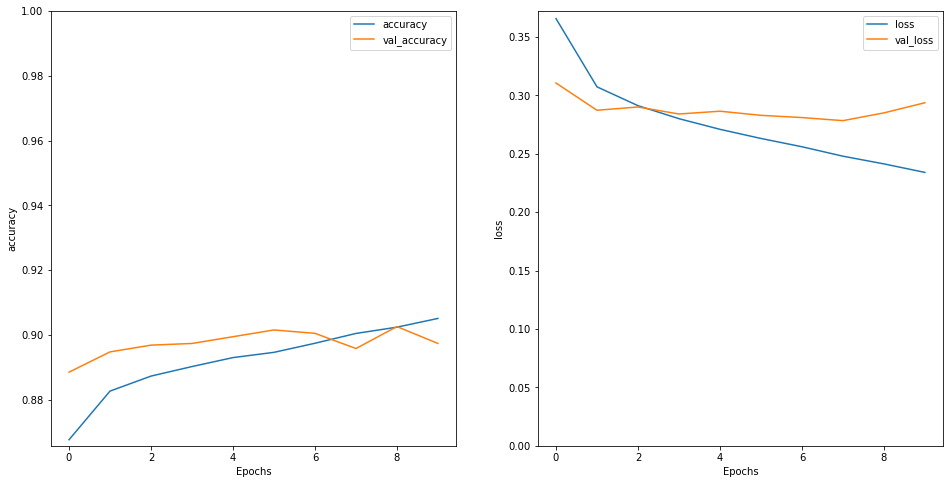

In [25]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [26]:
predictions = model.predict(['i need a place to dine in the center thats expensive'])
print(predictions[0])

[2.0157817e-01 4.0163822e-04 7.9802018e-01]


Run a prediction on a new sentence:

If the prediction is >= 0.0, it is positive else it is negative.

In [27]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

The interesting thing about using an `RNN` with `return_sequences=True` is that the output still has 3-axes, like the input, so it can be passed to another RNN layer, like this:

In [28]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [29]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [30]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
888/888 [==============================] - 120s 116ms/step - loss: -0.9031 - accuracy: 0.7501 - val_loss: -2.4432 - val_accuracy: 0.7792
Epoch 2/10
888/888 [==============================] - 91s 102ms/step - loss: -7.4936 - accuracy: 0.7524 - val_loss: -7.9170 - val_accuracy: 0.7922
Epoch 3/10
888/888 [==============================] - 119s 134ms/step - loss: -16.1544 - accuracy: 0.7577 - val_loss: -14.6483 - val_accuracy: 0.7911
Epoch 4/10
888/888 [==============================] - 125s 141ms/step - loss: -27.6533 - accuracy: 0.7625 - val_loss: -24.0669 - val_accuracy: 0.8036
Epoch 5/10
888/888 [==============================] - 112s 126ms/step - loss: -41.1000 - accuracy: 0.7623 - val_loss: -33.8728 - val_accuracy: 0.8031
Epoch 6/10
888/888 [==============================] - 104s 117ms/step - loss: -56.7412 - accuracy: 0.7644 - val_loss: -44.0896 - val_accuracy: 0.7937
Epoch 7/10
888/888 [==============================] - 98s 111ms/step - loss: -74.6876 - accuracy: 0.7644 

In [31]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

116/116 [==============================] - 3s 25ms/step - loss: -99.0318 - accuracy: 0.7930
Test Loss: -99.03175354003906
Test Accuracy: 0.7930005192756653


In [32]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

[[-0.24612916]]


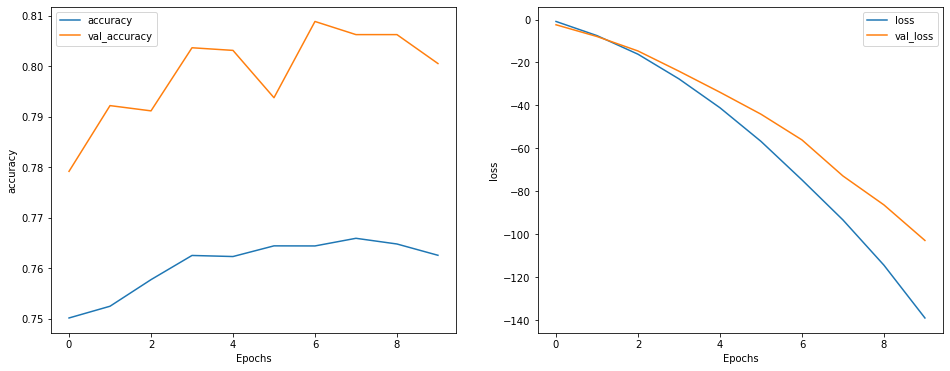

In [33]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

Check out other existing recurrent layers such as [GRU layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU).

If you're interestied in building custom RNNs, see the [Keras RNN Guide](https://www.tensorflow.org/guide/keras/rnn).
